In [2]:
import torch
import torch.nn as nn
import numpy as np

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from dataset import get_rays
from rendering import rendering
from model import Voxels, Nerf
from ml_helpers import training

In [10]:
print("torch version: ", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
else: 
    device = torch.device("cpu")

print("device: ", device)

torch version:  2.5.1
device:  mps


# Camera / Dataset

In [3]:
batch_size = 1024

o, d, target_px_values = get_rays('fox', mode='train')
dataloader = DataLoader(torch.cat((torch.from_numpy(o).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(d).reshape(-1, 3).type(torch.float),
                                   torch.from_numpy(target_px_values).reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


dataloader_warmup = DataLoader(torch.cat((torch.from_numpy(o).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(d).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float),
                               torch.from_numpy(target_px_values).reshape(90, 400, 400, 3)[:, 100:300, 100:300, :].reshape(-1, 3).type(torch.float)), dim=1),
                       batch_size=batch_size, shuffle=True)


test_o, test_d, test_target_px_values = get_rays('fox', mode='test')

# Training

100%|███████████████████████████████████████████████████████| 3516/3516 [04:42<00:00, 12.46it/s]


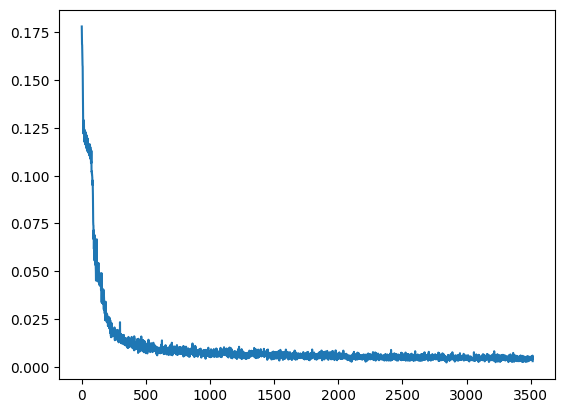

100%|█████████████████████████████████████████████████████| 14063/14063 [18:41<00:00, 12.54it/s]


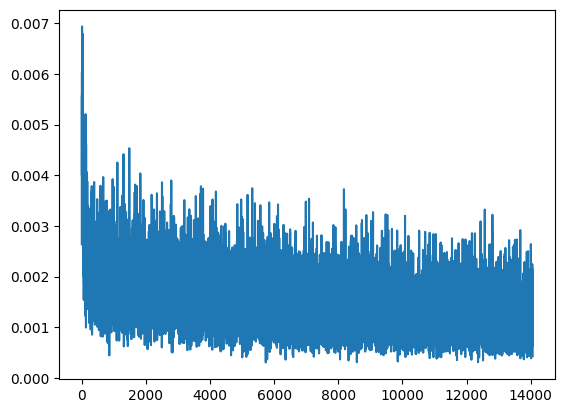

In [11]:
device = 'mps'

tn = 8.
tf = 12.
nb_epochs = 1
lr = 1e-3
gamma = .5
nb_bins = 100

model = Nerf(hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=gamma)



training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, 1, dataloader_warmup, device=device)
plt.plot(training_loss)
plt.show()
training_loss = training(model, optimizer, scheduler, tn, tf, nb_bins, nb_epochs, dataloader, device=device)
plt.plot(training_loss)
plt.show()

In [7]:
torch.save(model, 'model_nerf_mps')